In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium pygame

In [ ]:
import numpy as np
import random
from collections import deque
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv2D, Flatten,MaxPool2D
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import MeanSquaredError, MSE,mean_squared_error
from tensorflow import reduce_mean, convert_to_tensor, squeeze, float32, GradientTape
import gymnasium as gym
import numpy as np
import time
from PIL import Image
import os

In [ ]:
class DQN:
    def __init__(self, state_space_shape, num_actions, model, target_model, learning_rate=0.1,
                 discount_factor=0.95, batch_size=16, memory_size=100):
        """
        Initializes Deep Q Network agent.
        :param state_space_shape: shape of the observation space
        :param num_actions: number of actions
        :param model: Keras model
        :param target_model: Keras model
        :param learning_rate: learning rate
        :param discount_factor: discount factor
        :param batch_size: batch size
        :param memory_size: maximum size of the experience replay memory
        """
        self.state_space_shape = state_space_shape
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = model
        self.target_model = target_model
        self.update_target_model()

    def update_memory(self, state, action, reward, next_state, done):
        """
        Adds experience tuple to experience replay memory.
        :param state: current state
        :param action: performed action
        :param reward: reward received for performing action
        :param next_state: next state
        :param done: if episode has terminated after performing the action in the current state
        """
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        """
        Synchronize the target model with the main model.
        """
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state, epsilon):
        """
        Returns the best action following epsilon greedy policy for the current state.
        :param state: current state
        :param epsilon: exploration rate
        :return:
        """
        probability = np.random.random() + epsilon / self.num_actions
        if probability < epsilon:
            return np.random.randint(0, self.num_actions)
        else:
            if isinstance(self.state_space_shape, tuple):
                state = state.reshape((1,) + self.state_space_shape)
            else:
                state = state.reshape(1, self.state_space_shape)
            return np.argmax(self.model.predict(state,verbose=0)[0])

    def load(self, model_name):
        path="/content/drive/MyDrive/Colab Notebooks/abs_206009"
        """
        Loads the weights of the model at specified episode checkpoint.
        :param model_name: name of the model
        :param episode: episode checkpoint
        """
        self.model.load_weights(f'{path}/weights/{model_name}')

    def save(self, model_name, episode):
        """
        Stores the weights of the model at specified episode checkpoint.
        :param model_name: name of the model
        :param episode: episode checkpoint
        """
        path="/content/drive/MyDrive/Colab Notebooks/abs_206009"
        if not os.path.exists(f"{path}/weights/"):
            os.mkdir(f"{path}/weights")
        self.model.save_weights(f'{path}/weights/{model_name}_{episode}.h5')

    def train(self):
        """
        Performs one step of model training.
        """
        batch_size = min(self.batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)

        if isinstance(self.state_space_shape, tuple):
            states = np.zeros((batch_size,) + self.state_space_shape)
        else:
            states = np.zeros((batch_size, self.state_space_shape))
        actions = np.zeros((batch_size, self.num_actions))

        for i in range(len(minibatch)):
            state, action, reward, next_state, done = minibatch[i]
            if done:
                max_future_q = reward
            else:
                if isinstance(self.state_space_shape, tuple):
                    next_state = next_state.reshape((1,) + self.state_space_shape)
                else:
                    next_state = next_state.reshape(1, self.state_space_shape)
                max_future_q = (reward + self.discount_factor *
                                np.amax(self.target_model.predict(next_state,verbose=0)[0]))
            if isinstance(self.state_space_shape, tuple):
                state = state.reshape((1,) + self.state_space_shape)
            else:
                state = state.reshape(1, self.state_space_shape)
            target_q = self.model.predict(state,verbose=0)[0]
            target_q[action] = max_future_q
            states[i] = state
            actions[i] = target_q

        self.model.train_on_batch(states, actions)


In [ ]:
class DDQN:
    def __init__(self, state_space_shape, num_actions, model, target_model, learning_rate=0.1,
                 discount_factor=0.95, batch_size=16, memory_size=100):
        """
        Initializes Double Deep Q Network agent.
        :param state_space_shape: shape of the observation space
        :param num_actions: number of actions
        :param model: Keras model
        :param target_model: Keras model
        :param learning_rate: learning rate
        :param discount_factor: discount factor
        :param batch_size: batch size
        :param memory_size: maximum size of the experience replay memory
        """
        self.state_space_shape = state_space_shape
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = model
        self.target_model = target_model
        self.update_target_model()

    def update_memory(self, state, action, reward, next_state, done):
        """
        Adds experience tuple to experience replay memory.
        :param state: current state
        :param action: performed action
        :param reward: reward received for performing action
        :param next_state: next state
        :param done: if episode has terminated after performing the action in the current state
        """
        self.memory.append((state, action, reward, next_state, done))

    def update_target_model(self):
        """
        Synchronize the target model with the main model.
        """
        self.target_model.set_weights(self.model.get_weights())

    def get_action(self, state, epsilon):
        """
        Returns the best action following epsilon greedy policy for the current state.
        :param state: current state
        :param epsilon: exploration rate
        :return:
        """
        probability = np.random.random() + epsilon / self.num_actions
        if probability < epsilon:
            return np.random.randint(0, self.num_actions)
        else:
            if isinstance(self.state_space_shape, tuple):
                state = state.reshape((1,) + self.state_space_shape)
            else:
                state = state.reshape(1, self.state_space_shape)
            return np.argmax(self.model.predict(state,verbose=0)[0])

    def load(self, model_name):
        path="/content/drive/MyDrive/Colab Notebooks/abs_206009"
        """
        Loads the weights of the model at specified episode checkpoint.
        :param model_name: name of the model
        :param episode: episode checkpoint
        """
        self.model.load_weights(f'{path}/weights/{model_name}')

    def save(self, model_name, episode):
        """
        Stores the weights of the model at specified episode checkpoint.
        :param model_name: name of the model
        :param episode: episode checkpoint
        """
        path="/content/drive/MyDrive/Colab Notebooks/abs_206009"
        if not os.path.exists(f"{path}/weights/"):
            os.mkdir(f"{path}/weights")
        self.model.save_weights(f'{path}/weights/{model_name}_{episode}.h5')

    def train(self):
        """
        Performs one step of model training.
        """
        batch_size = min(self.batch_size, len(self.memory))
        minibatch = random.sample(self.memory, batch_size)

        if isinstance(self.state_space_shape, tuple):
            states = np.zeros((batch_size,) + self.state_space_shape)
        else:
            states = np.zeros((batch_size, self.state_space_shape))
        actions = np.zeros((batch_size, self.num_actions))

        for i in range(len(minibatch)):
            state, action, reward, next_state, done = minibatch[i]
            if done:
                max_future_q = reward
            else:
                if isinstance(self.state_space_shape, tuple):
                    next_state = next_state.reshape((1,) + self.state_space_shape)
                else:
                    next_state = next_state.reshape(1, self.state_space_shape)
                max_action = np.argmax(self.model.predict(next_state,verbose=0)[0])
                max_future_q = (reward + self.discount_factor *
                                self.target_model.predict(next_state,verbose=0)[0][max_action])
            if isinstance(self.state_space_shape, tuple):
                state = state.reshape((1,) + self.state_space_shape)
            else:
                state = state.reshape(1, self.state_space_shape)
            target_q = self.model.predict(state,verbose=0)[0]
            target_q[action] = max_future_q
            states[i] = state
            actions[i] = target_q

        self.model.train_on_batch(states, actions)

In [ ]:
def build_model1(state_space_shape, num_actions):
    model = Sequential()
    model.add(Dense(16, input_shape=state_space_shape))
    model.add(Dense(16))
    model.add(Dense(num_actions, activation='linear'))
    model.compile(SGD(0.001), mean_squared_error)
    return model

In [ ]:
def build_model2(state_space_shape, num_actions):
    model = Sequential()
    model.add(Dense(state_space_shape[0], input_shape=state_space_shape))
    model.add(Dense(12,activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_actions, activation='linear'))
    model.compile(Adam(learning_rate=0.001), mean_squared_error)
    return model

In [ ]:
def build_model3(state_space_shape,num_actions):

    model = Sequential()

    model.add(Dense(state_space_shape[0], input_shape=state_space_shape,activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(num_actions, activation="linear"))

    model.compile(loss="mse", optimizer=Adam(learning_rate=0.0001))
    return model

In [ ]:
env = gym.make("Acrobot-v1")
state,_=env.reset()

In [ ]:
num_episodes=10
epsilon=0.1

state_space_shape = env.observation_space.shape
num_actions = env.action_space.n

In [ ]:
models_dqn=[
    'dqn_acrobot_model1.h5',
    'dqn_acrobot_model2.h5',
    'dqn_acrobot_model3.h5'
]
models_ddqn=[
    'ddqn_acrobot_model1.h5',
    'ddqn_acrobot_model2.h5',
    'ddqn_acrobot_model3.h5'
]

In [ ]:
model = build_model1(state_space_shape, num_actions)
target_model = build_model1(state_space_shape, num_actions)
agent = DQN(state_space_shape, num_actions, model, target_model,memory_size=1000000)

agent.load('dqn_acrobot_model1.h5')
rewards = 0
steps = 0
for episode in range(num_episodes):

  state, _ = env.reset()
  terminated = False
  while not terminated:
      steps += 1
      action = agent.get_action(state, epsilon)
      new_state, reward, terminated, _, _ = env.step(action)

      if terminated:
          reward=int(10_000/steps)

      rewards += reward

      agent.update_memory(state, action, reward, new_state, terminated)
      state = new_state

rewards/=num_episodes
steps/=num_episodes

print("Average reward for","dqn_acrobot_model1",":",rewards)
print("Average number of steps for","dqn_acrobot_model1",":",steps)


Average reward for dqn_acrobot_model1 : -1098.0
Average number of steps for dqn_acrobot_model1 : 1101.4


In [ ]:
model = build_model2(state_space_shape, num_actions)
target_model = build_model2(state_space_shape, num_actions)
agent = DQN(state_space_shape, num_actions, model, target_model,memory_size=1000000)

agent.load('dqn_acrobot_model2.h5')
rewards = 0
steps = 0
for episode in range(num_episodes):

  state, _ = env.reset()
  terminated = False
  while not terminated:
      steps += 1
      action = agent.get_action(state, epsilon)
      new_state, reward, terminated, _, _ = env.step(action)

      if terminated:
          reward=int(10_000/steps)

      rewards += reward

      agent.update_memory(state, action, reward, new_state, terminated)
      state = new_state

rewards/=num_episodes
steps/=num_episodes

print("Average reward for","dqn_acrobot_model2",":",rewards)
print("Average number of steps for","dqn_acrobot_model2",":",steps)


Average reward for dqn_acrobot_model2 : -764.2
Average number of steps for dqn_acrobot_model2 : 771.3


In [ ]:
model = build_model3(state_space_shape, num_actions)
target_model = build_model3(state_space_shape, num_actions)
agent = DQN(state_space_shape, num_actions, model, target_model,memory_size=1000000)

agent.load('dqn_acrobot_model3.h5')
rewards = 0
steps = 0
for episode in range(num_episodes):

  state, _ = env.reset()
  terminated = False
  while not terminated:
      steps += 1
      action = agent.get_action(state, epsilon)
      new_state, reward, terminated, _, _ = env.step(action)

      if terminated:
          reward=int(10_000/steps)

      rewards += reward

      agent.update_memory(state, action, reward, new_state, terminated)
      state = new_state

rewards/=num_episodes
steps/=num_episodes

print("Average reward for","dqn_acrobot_model3",":",rewards)
print("Average number of steps for","dqn_acrobot_model3",":",steps)


Average reward for dqn_acrobot_model3 : -161.5
Average number of steps for dqn_acrobot_model3 : 178.7


In [ ]:
model = build_model1(state_space_shape, num_actions)
target_model = build_model1(state_space_shape, num_actions)
agent = DDQN(state_space_shape, num_actions, model, target_model,memory_size=1000000)

agent.load('ddqn_acrobot_model1.h5')
rewards = 0
steps = 0
for episode in range(num_episodes):

  state, _ = env.reset()
  terminated = False
  while not terminated:
      steps += 1
      action = agent.get_action(state, epsilon)
      new_state, reward, terminated, _, _ = env.step(action)

      if terminated:
          reward=int(10_000/steps)

      rewards += reward

      agent.update_memory(state, action, reward, new_state, terminated)
      state = new_state

rewards/=num_episodes
steps/=num_episodes

print("Average reward for","ddqn_acrobot_model1",":",rewards)
print("Average number of steps for","ddqn_acrobot_model1",":",steps)


Average reward for ddqn_acrobot_model1 : -451.8
Average number of steps for ddqn_acrobot_model1 : 457.6


In [ ]:
model = build_model2(state_space_shape, num_actions)
target_model = build_model2(state_space_shape, num_actions)
agent = DDQN(state_space_shape, num_actions, model, target_model,memory_size=1000000)

agent.load('ddqn_acrobot_model2.h5')
rewards = 0
steps = 0
for episode in range(num_episodes):

  state, _ = env.reset()
  terminated = False
  while not terminated:
      steps += 1
      action = agent.get_action(state, epsilon)
      new_state, reward, terminated, _, _ = env.step(action)

      if terminated:
          reward=int(10_000/steps)

      rewards += reward

      agent.update_memory(state, action, reward, new_state, terminated)
      state = new_state

rewards/=num_episodes
steps/=num_episodes

print("Average reward for","ddqn_acrobot_model2",":",rewards)
print("Average number of steps for","ddqn_acrobot_model2",":",steps)


Average reward for ddqn_acrobot_model2 : -1462.5
Average number of steps for ddqn_acrobot_model2 : 1465.3


In [ ]:
model = build_model3(state_space_shape, num_actions)
target_model = build_model3(state_space_shape, num_actions)
agent = DDQN(state_space_shape, num_actions, model, target_model,memory_size=1000000)

agent.load('ddqn_acrobot_model3.h5')
rewards = 0
steps = 0
for episode in range(num_episodes):

  state, _ = env.reset()
  terminated = False
  while not terminated:
      steps += 1
      action = agent.get_action(state, epsilon)
      new_state, reward, terminated, _, _ = env.step(action)

      if terminated:
          reward=int(10_000/steps)

      rewards += reward

      agent.update_memory(state, action, reward, new_state, terminated)
      state = new_state

rewards/=num_episodes
steps/=num_episodes

print("Average reward for","ddqn_acrobot_model3",":",rewards)
print("Average number of steps for","ddqn_acrobot_model3",":",steps)


Average reward for ddqn_acrobot_model3 : -476.7
Average number of steps for ddqn_acrobot_model3 : 483.7


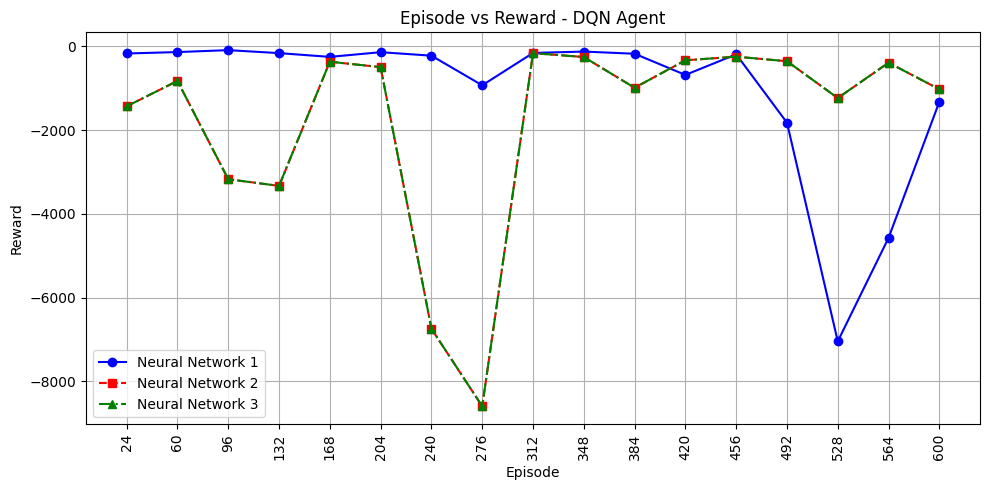

In [36]:
import matplotlib.pyplot as plt

# Sample data
episodes = [i*12 for i in range(1,51)]  # x-axis: number of episodes
rewards1 = [-136.0,-170.0,-334.0,-159.0,-136.0,-235.0,-185.0,-90.0,-182.0, -205.0, -161.0, -73.0, -70.0, -251.0, -54.0, -185.0, -139.0, -128.0, -316.0, -222.0, -93.0, -188.0, -930.0, -308.0, -129.0, -157.0, -124.0, -481.0, -124.0, -128.0, -100.0, -176.0, -220.0, -184.0, -682.0, -1095.0, -929.0, -190.0, -3299.0, -1648.0, -1823.0, -1304.0, -867.0, -7045.0, -3544.0, -3963.0, -4573.0, -6521.0, -734.0, -1322.0]
rewards2 = [-739.0,-1432.0,-1312.0,-2757.0,-825.0,-1286.0,-1652.0,-3173.0,-3420.0, -1752.0, -3332.0, -435.0, -2284.0, -366.0, -374.0, -15230.0, -496.0, -438.0, -12088.0, -6744.0, -1210.0, -1986.0, -8596.0, -3690.0, -1069.0, -162.0, -10310.0, -4593.0, -254.0, -6033.0, -1548.0, -989.0, -365.0, -1125.0, -332.0, -304.0, -275.0, -246.0, -301.0, -579.0, -355.0, -561.0, -388.0, -1234.0, -679.0, -908.0, -390.0, -418.0, -549.0, -1024.0]
rewards3 = [-739.0,-1432.0,-1312.0,-2757.0,-825.0,-1286.0,-1652.0,-3173.0,-3420.0, -1752.0, -3332.0, -435.0, -2284.0, -366.0, -374.0, -15230.0, -496.0, -438.0, -12088.0, -6744.0, -1210.0, -1986.0, -8596.0, -3690.0, -1069.0, -162.0, -10310.0, -4593.0, -254.0, -6033.0, -1548.0, -989.0, -365.0, -1125.0, -332.0, -304.0, -275.0, -246.0, -301.0, -579.0, -355.0, -561.0, -388.0, -1234.0, -679.0, -908.0, -390.0, -418.0, -549.0, -1024.0]


rewards1 =[int(i) for i in rewards1]
rewards2 =[int(i) for i in rewards2]
rewards3 =[int(i) for i in rewards3]

episodes=episodes[1::3]
rewards1=rewards1[1::3]
rewards2=rewards2[1::3]
rewards3=rewards3[1::3]
# Create the line plot
plt.figure(figsize=(10, 5))

# Plot each reward list
plt.plot(episodes, rewards1, marker='o', linestyle='-', color='b', label='Neural Network 1')
plt.plot(episodes, rewards2, marker='s', linestyle='--', color='r', label='Neural Network 2')
plt.plot(episodes, rewards3, marker='^', linestyle='-.', color='g', label='Neural Network 3')

# Adding titles and labels
plt.title('Episode vs Reward - DQN Agent')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Ensuring integer display on x-axis and y-axis
plt.xticks(episodes,rotation=90)
# plt.yticks(range(min(rewards1+ rewards2+ rewards3), max(rewards1+ rewards2+rewards3) + 1,200))

# Adding a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


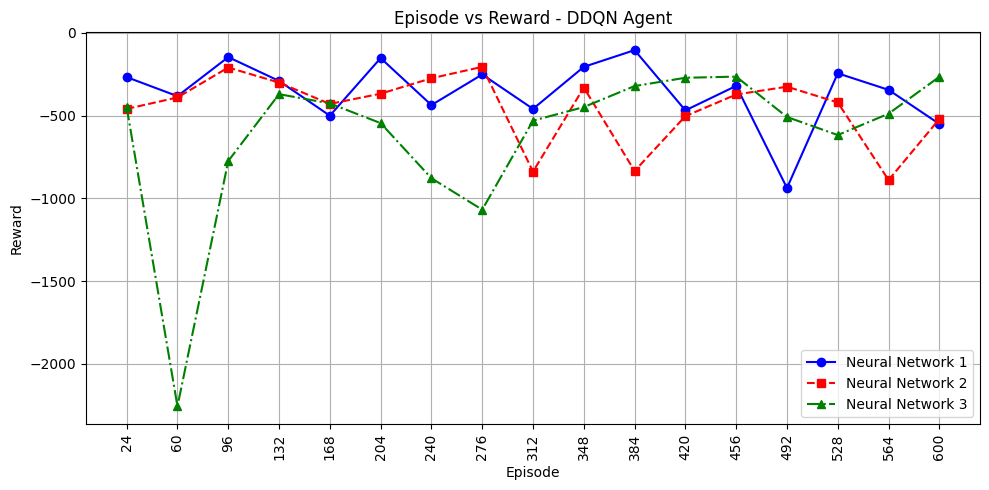

In [37]:
import matplotlib.pyplot as plt

# Sample data
episodes = [12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 252, 264, 276, 288, 300, 312, 324, 336, 348, 360, 372, 384, 396, 408, 420, 432, 444, 456, 468, 480, 492, 504, 516, 528, 540, 552, 564, 576, 588, 600]
rewards1 = [-433.0,-267.0,-159.0,-488.0,-382.0,-284.0,-657.0,-146.0,-230.0,-119.0,-290.0,-591.0,-632.0,-500.0,-407.0,-518.0,-152.0,-192.0,-380.0,-436.0,-103.0,-185.0,-251.0,-1544.0,-425.0,-459.0,-427.0,-560.0,-205.0,-288.0,-533.0,-104.0,-804.0,-842.0,-468.0,-249.0,-416.0,-320.0,-391.0,-469.0,-937.0,-551.0,-306.0,-244.0,-556.0,-677.0,-344.0,-601.0,-261.0,-550.0]
rewards2 = [-255.0,-459.0,-474.0,-586.0,-390.0,-301.0,-418.0,-209.0,-174.0,-423.0,-300.0,-299.0,-173.0,-429.0,-448.0,-292.0,-367.0,-372.0,-307.0,-274.0,-244.0,-236.0,-205.0,-431.0,-425.0,-838.0,-248.0,-344.0,-330.0,-230.0,-266.0,-834.0,-495.0,-712.0,-503.0,-614.0,-601.0,-372.0,-1519.0,-762.0,-325.0,-242.0,-536.0,-420.0,-1194.0,-1848.0,-889.0,-1857.0,-6398.0,-520.0]
rewards3 = [-304.0,-448.0,-337.0,-801.0,-2256.0,-679.0,-1007.0,-774.0,-387.0,-904.0,-370.0,-294.0,-410.0,-426.0,-306.0,-420.0,-545.0,-379.0,-306.0,-878.0,-583.0,-484.0,-1068.0,-615.0,-463.0,-530.0,-325.0,-426.0,-448.0,-293.0,-286.0,-321.0,-554.0,-255.0,-271.0,-311.0,-449.0,-264.0,-298.0,-308.0,-508.0,-362.0,-265.0,-617.0,-192.0,-372.0,-488.0,-347.0,-234.0,-265.0]


rewards1 =[int(i) for i in rewards1]
rewards2 =[int(i) for i in rewards2]
rewards3 =[int(i) for i in rewards3]

episodes=episodes[1::3]
rewards1=rewards1[1::3]
rewards2=rewards2[1::3]
rewards3=rewards3[1::3]
# Create the line plot
plt.figure(figsize=(10, 5))

# Plot each reward list
plt.plot(episodes, rewards1, marker='o', linestyle='-', color='b', label='Neural Network 1')
plt.plot(episodes, rewards2, marker='s', linestyle='--', color='r', label='Neural Network 2')
plt.plot(episodes, rewards3, marker='^', linestyle='-.', color='g', label='Neural Network 3')

# Adding titles and labels
plt.title('Episode vs Reward - DDQN Agent')
plt.xlabel('Episode')
plt.ylabel('Reward')

# Ensuring integer display on x-axis and y-axis
plt.xticks(episodes,rotation=90)
# plt.yticks(range(min(rewards1+ rewards2+ rewards3), max(rewards1+ rewards2+rewards3) + 1,200))

# Adding a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


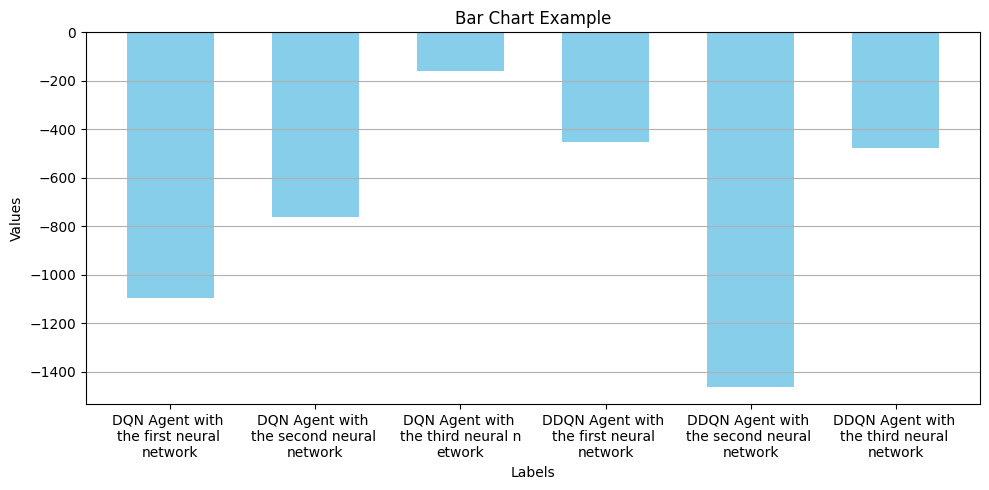

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
labels = ['DQN Agent with \nthe first neural \nnetwork', 'DQN Agent with \nthe second neural \nnetwork', 'DQN Agent with \nthe third neural n\network', 'DDQN Agent with \nthe first neural \nnetwork', 'DDQN Agent with \nthe second neural \nnetwork', 'DDQN Agent with \nthe third neural \nnetwork']  # List of labels
values = [-1098, -764, -161, -451, -1462,-476]  # List of numbers

# Create the bar chart
plt.figure(figsize=(10, 5))

# Adjust bar width and spacing
bar_width = 0.6
spacing = 1.0
bar_positions = np.arange(len(labels)) * spacing

plt.bar(bar_positions, values, width=bar_width, color='skyblue')

# Adding titles and labels
plt.title('Bar Chart Example')
plt.xlabel('Labels')
plt.ylabel('Values')

# Adjust x-axis ticks to match labels with their bars
plt.xticks(bar_positions, labels)

# Show the plot
plt.grid(True, axis='y')
plt.tight_layout()  # Adjust layout to make room for rotated x-ticks
plt.show()
